# Buffer Stock Saving in HARK and dolo
<!-- <p style="text-align: center;"><small><small>Generator: BufferStockTheory-make/notebooks_byname</small></small></p>
-->

This notebook compares the solutions to a standard buffer stock saving model obtained by the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit and the [dolo](https://github.com/EconForge/dolo) modeling system.

## [The Problem](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem) 

[This paper](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem) defines a buffer stock saving model and calibrates parameters:

| Parameter | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\newcommand{\PermGroFac}{\Gamma}\PermGroFac$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.03 |
| $\newcommand{\Rfree}{\mathrm{\mathsf{R}}}\Rfree$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |
| $\newcommand{\DiscFac}{\beta}\DiscFac$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
| $\newcommand{\CRRA}{\rho}\CRRA$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\newcommand{\UnempPrb}{\wp}\UnempPrb$ | Probability of Unemployment | $\texttt{UnempPrb}$ | 0.005 |
| $\newcommand{\IncUnemp}{\mu}\IncUnemp$ | Income when Unemployed | $\texttt{IncUnemp}$ | 0. |
| $\newcommand{\PermShkStd}{\sigma_\psi}\PermShkStd$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
| $\newcommand{\TranShkStd}{\sigma_\theta}\TranShkStd$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

For a microeconomic consumer with 'Market Resources' $M_{t}$ (net worth plus current income; basically, everything the consumer owns), end-of-period assets $A_{t}$ will be the amount remaining after consuming $C_{t}$:  <!-- Next period's 'Balances' $B_{t+1}$ reflect this period's $A_{t}$ augmented by return factor $R$:-->
\begin{eqnarray}
A_{t} & = & M_{t} - C_{t}  \label{eq:DBCparts}
\end{eqnarray}

The consumer's permanent noncapital income $P$ (in the sense of [Friedman (1957)](http://www.econ2.jhu.edu/people/ccarroll/ATheoryv3NBER.pdf)) grows by a predictable factor $\PermGroFac$ and is subject to an unpredictable lognormally distributed multiplicative shock $\mathbb{E}_{t}[\psi_{t+1}]=1$, 
\begin{eqnarray}
P_{t+1} & = & P_{t} \PermGroFac \psi_{t+1}
\end{eqnarray}
and actual income is permanent income multiplied by a logormal multiplicative transitory shock, $\mathbb{E}_{t}[\theta_{t+1}]=1$, so that next period's market resources are
\begin{eqnarray}
%M_{t+1} &=& B_{t+1} +P_{t+1}\theta_{t+1},  \notag
M_{t+1} &=& A_{t}R +P_{t+1}\theta_{t+1}.  \notag
\end{eqnarray}

When the consumer has a standard Constant Relative Risk Aversion utility function $u(c)=\frac{c^{1-\rho}}{1-\rho}$, [the paper shows](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Problem-Can-Be-Rewritten-in-Ratio-Form) that the problem can be written in terms of ratios of money variables to permanent income, e.g. $m_{t} \equiv M_{t}/P_{t}$, and the Bellman form of [the problem reduces to](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#The-Related-Problem):

\begin{align*}
v_t(m_t) &=& \max_{c_t}~~ u(c_t) + \beta~\mathbb{E}_{t} [(\Gamma\psi_{t+1})^{1-\rho} v_{t+1}(m_{t+1}) ] \\
& s.t. & \\
a_t &=& m_t - c_t \\
m_{t+1} &=& R/(\Gamma \psi_{t+1}) a_t + \theta_{t+1} \\
\end{align*}

and the [Euler equation](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/Consumption/Envelope) for this model is 

\begin{align*}
c_{t}^{-\rho} & = R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1})^{-\rho})] %\\
% 0 & = & R \beta \mathbb{E}_{t}[(\Gamma \psi c_{t+1}/c_{t})^{-\rho})]-1
\end{align*}


For the purposes of this notebook, [the paper's](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory) baseline [parameterization](http://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/#Baseline-Numerical-Solution) is changed as follows:

1. The unemployment (zero-income event) shocks are turned off
2. An explicit liqudity constraint is added ($c_{t} \leq m_{t}$); that is, the consumer is prohibited from borrowing

In [2]:
# Tools for navigating the filesystem
import sys
import os

# Find the notebook's own path
my_file_path = os.path.dirname(os.path.abspath("BufferStockTheory.py"))

# Obtain the solution to the model using the HARK toolkit (see the standalone BufferStockTheory_HARK notebook)
exec(open(my_file_path+r'/BufferStock_HARK.py').read())

# Obtain the solution using dolo (see the standalone BufferStockTheory_dolo notebook)
exec(open(my_file_path+r'/BufferStock_dolo.py').read())

ModuleNotFoundError: No module named 'HARK.ConsumptionSaving.ConsumerParameters'

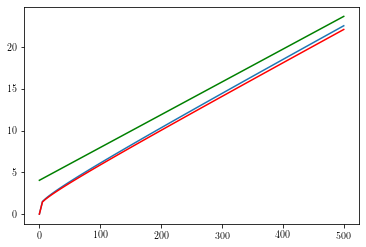

In [3]:
# Plot the results: Green is perfect foresight, red is HARK, black is dolo

tab = tabulate(model_dolo, dr, 'm') # Tabulate points on the dolo decision rule
plt.plot(tab['m'],tab['c'])     # This is pretty cool syntax
m = tab.iloc[:,2]
c_m  = model_HARK.cFunc[0](m)   # Get points on the HARK consumption rule
# cPF uses the analytical formula for the perfect foresight solution
cPF = (np.array(m)-1+1/(1-PermGroFac/Rfree))*((Rfree-(Rfree * DiscFac)**(1/CRRA))/Rfree)
plt.plot(tab['m'],c_m,color="red")
plt.plot(m,cPF,color="green")

### [Upper and Lower Limits of the Marginal Propensity to Consume](https://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/#MPCLimits)

The paper shows that as $m_{t}~\uparrow~\infty$ the consumption function in the presence of risk gets arbitrarily close to the perfect foresight consumption function.  Defining κ as the perfect foresight model's MPC, this implies that $\lim_{m_{t}~\uparrow~\infty} c^{\prime}(m) = $ κ.

In the presence of the liquidity constraint and a positive minimum value of $m$, there will be a point at which the consumer becomes liquidity constrained and sets $c(m) = m$.  Below that $m$, the MPC is 1.0.

In [4]:
# Define k_lower, h_inf and perfect foresight consumption function, upper bound of consumption function and lower
# bound of consumption function.
k_lower = 1.0-(model_HARK.Rfree**(-1.0))*(model_HARK.Rfree*model_HARK.DiscFac)**(1.0/model_HARK.CRRA)

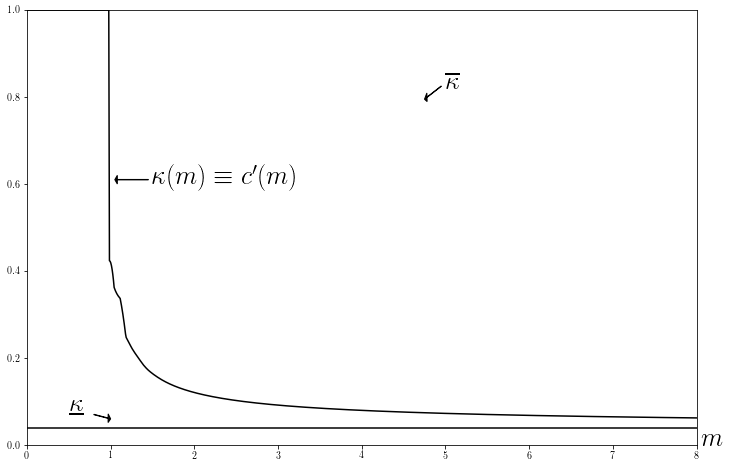

In [5]:
# The last figure shows the upper and lower limits of the MPC
plt.figure(figsize = (12,8))
# Set the plot range of m
m = np.linspace(0.001,8,1000)

# Use the HARK method derivative to get the derivative of cFunc, and the values are just the MPC
MPC = model_HARK.cFunc[0].derivative(m)

# Define the lower bound of MPC
MPCLower = k_lower

kappaDef=r'$\underline{\kappa}$'
if not iflatexExists:
    kappaDef=r'κ̲$\equiv(1-\Phi_{R})$'

plt.plot(m,MPC,color = 'black')
plt.plot([0,8],[MPCLower,MPCLower],color = 'black')
plt.xlim(0,8)
plt.ylim(0,1)
plt.text(1.5,0.6,r'$\kappa(m) \equiv c^{\prime}(m)$',fontsize = 26,fontweight='bold')
plt.arrow(1.45,0.61,-0.4,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

# if iflatexExists:
#     plt.text(5,.82,r'$\overline{\kappa}$',fontsize = 26,fontweight='bold')
# else:
#     plt.text(5,0.82,r'$(1-\wp^{1/\rho}\Phi_{R})\equiv \overline{\kappa}$',fontsize = 26,fontweight='bold')
# plt.arrow(4.95,0.825,-0.2,-0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

plt.text(0.5,0.07,kappaDef,fontsize = 26,fontweight='bold')
plt.text(8.05,0,"$m$",fontsize = 26)
plt.arrow(.8,0.07,0.2,-0.01,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')

if Generator:
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.png'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.jpg'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.pdf'))
    plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.svg'))
if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True) # Change to False if you want to run uninterrupted